<a href="https://colab.research.google.com/github/geologist8268/M-Nawaz/blob/master/OpenET_Ensemble_Monthly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00


In [7]:
ee.Authenticate()
ee.Initialize(
    project = 'researchlmi',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [8]:
#Map = geemap.Map(center=[30.47, 67.68], zoom=13)
#Map.add_basemap('Google Satellite')
#Map.add_basemap('Google Hybrid')
map = geemap.Map(basemap = 'SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [9]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          -474.33598,
                          42.398108
                        ],
                        [
                          -474.33598,
                          42.589489
                        ],
                        [
                          -473.834873,
                          42.589489
                        ],
                        [
                          -473.834873,
                          42.398108
                        ],
                        [
                          -474.33598,
                          42.398108
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [18]:
time_start = ee.Date('2024')
time_end = ee.Date('2025')
time_dif = time_end.difference(time_start, 'month').round()
time_list = ee.List.sequence(0, ee.Number(time_dif).subtract(1)).map(
    lambda x: time_start.advance(x, 'month')
)

def monthly(date, col):
  start_date = ee.Date(date)
  end_date = start_date.advance(1, 'month')
  col_img = col.filterDate(start_date, end_date).median()
  return col_img.set('system:time_start', start_date.millis())

et = (
    ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0')
    .filterDate(time_start,time_end)
    .filterBounds(roi)
    .select('et_ensemble_mad')
)

monthly_et = (
    ee.ImageCollection(time_list.map(lambda x: monthly(x, et)))
)

def oli(img):
  qa = img.select('QA_PIXEL')
  dil = qa.bitwiseAnd(1 << 1).neq(0)
  cir = qa.bitwiseAnd(1 << 2).neq(0)
  clo = qa.bitwiseAnd(1 << 3).neq(0)
  sha = qa.bitwiseAnd(1 << 4).neq(0)
  mask = dil.Or(cir).Or(clo).Or(sha)
  sr = img.select('SR_.*').multiply(2.75e-05).add(-0.2)
  ndvi = sr.normalizedDifference(['SR_B5', 'SR_B4']).rename('ndvi')
  temp = img.select('ST_B10').multiply(0.00341802).add(149).rename('lst')
  return ndvi.addBands(temp).updateMask(mask.Not()).copyProperties(img, ['system:time_start'])



l8 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate(time_start, time_end)
    .filterBounds(roi)
    .map(oli)
)

l9 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(time_start, time_end)
    .filterBounds(roi)
    .map(oli)
)
landsat = l8.merge(l9).sort('system:time_start')

landsat_monthly = (
    ee.ImageCollection(time_list.map(lambda x: monthly(x, landsat)))
)
collection = landsat_monthly.combine(monthly_et)

collection

In [19]:
ds = xr.open_dataset(
    collection,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.001,
    geometry = roi
)

ds

<xarray.Dataset> Size: 14MB
Dimensions:          (time: 12, lon: 501, lat: 191)
Coordinates:
  * time             (time) datetime64[ns] 96B 2024-01-01 ... 2024-10-01
  * lon              (lon) float64 4kB -114.3 -114.3 -114.3 ... -113.8 -113.8
  * lat              (lat) float64 2kB 42.4 42.4 42.4 42.4 ... 42.59 42.59 42.59
Data variables:
    ndvi             (time, lon, lat) float32 5MB ...
    lst              (time, lon, lat) float32 5MB ...
    et_ensemble_mad  (time, lon, lat) float32 5MB ...
Attributes:
    crs:      EPSG:4326

In [20]:
ds = ds.sortby('time') * 1

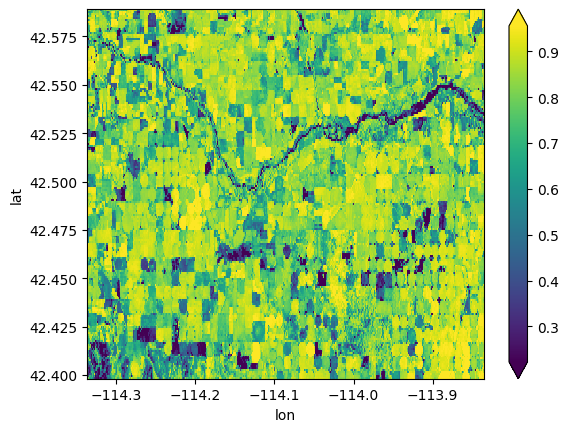

In [25]:
ndvi_et = xr.corr(ds.ndvi, ds.et_ensemble_mad, dim = 'time')
ndvi_et.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

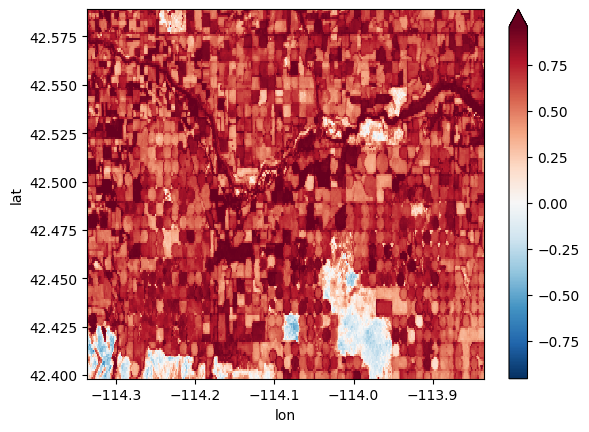

In [26]:
temp_et = xr.corr(ds.lst, ds.et_ensemble_mad, dim = 'time')
temp_et.plot(
    x = 'lon',
    y = 'lat',
    robust = True
)

In [21]:
df = ds.to_dataframe().dropna()
df

ndvi         lst  et_ensemble_mad
time       lon        lat                                             
2024-01-01 -114.33548 42.398608  0.164141  284.774017              1.0
                      42.399608  0.058096  282.297638              4.0
                      42.400608  0.109214  280.947540              9.0
                      42.401608  0.168807  279.705078             13.0
                      42.402608  0.129132  279.771729             13.0
...                                   ...         ...              ...
2024-12-01 -113.83548 42.584608  0.186979  275.466736             17.0
                      42.585608  0.159770  275.336853             17.0
                      42.586608  0.173967  275.036072             16.0
                      42.587608  0.152785  274.979675             16.0
                      42.588608  0.177949  275.080505             16.0

[1146702 rows x 3 columns]

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x = df[['ndvi', 'lst']]
y = df['et_ensemble_mad']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, random_state = 42, test_size = 0.2
)

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
model = RandomForestRegressor(
    n_estimators = 100, random_state = 42
)

model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
y_pred = model.predict(x_test)

In [30]:
r2 = r2_score(y_test, y_pred)
r2

0.799803948540672

In [31]:
import numpy as np

In [32]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

np.float64(24.31804899756052)

In [33]:
df['et_pred'] = model.predict(df[['ndvi', 'lst']])

In [34]:
dfx = df.to_xarray().sortby(['lon', 'lat', 'time'])

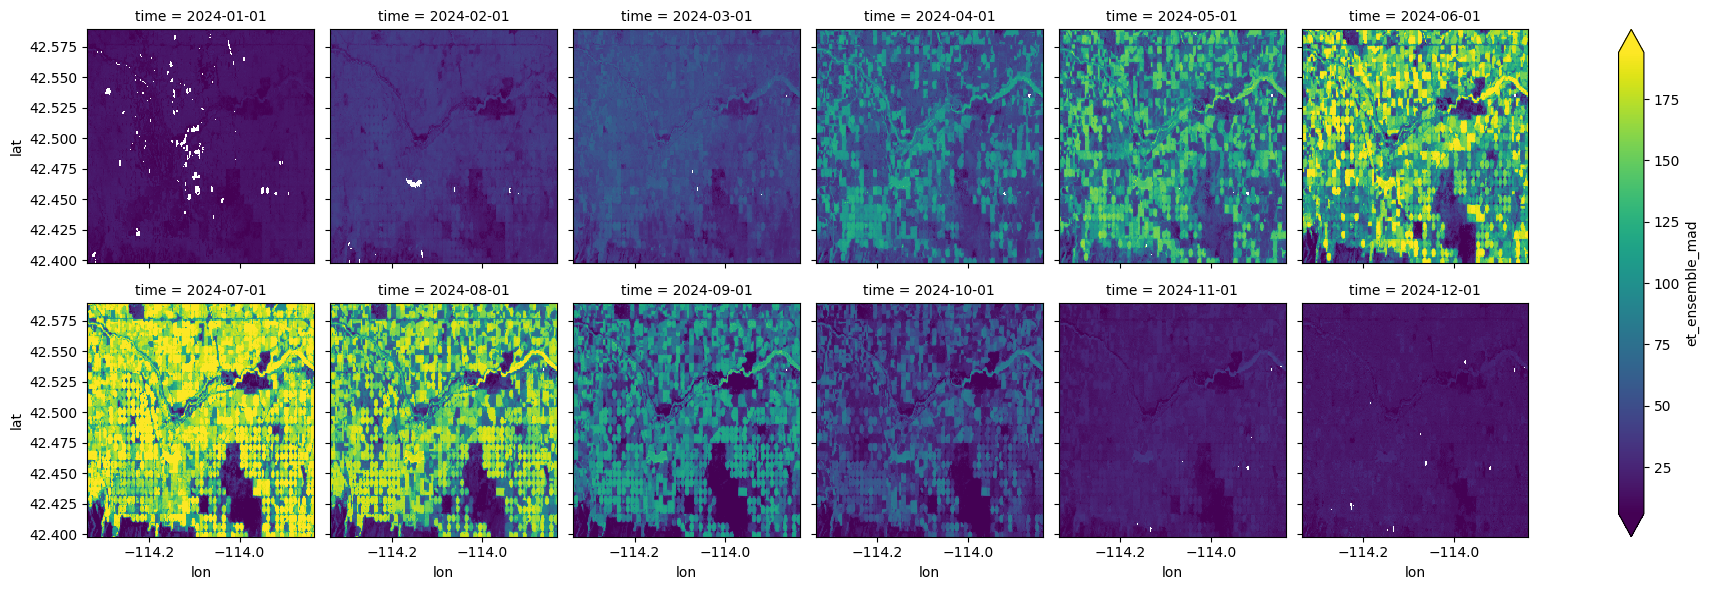

In [35]:
dfx.et_ensemble_mad.plot(
    x = 'lon',
    y = 'lat',
    robust = True,
    col = 'time',
    col_wrap = 6
)

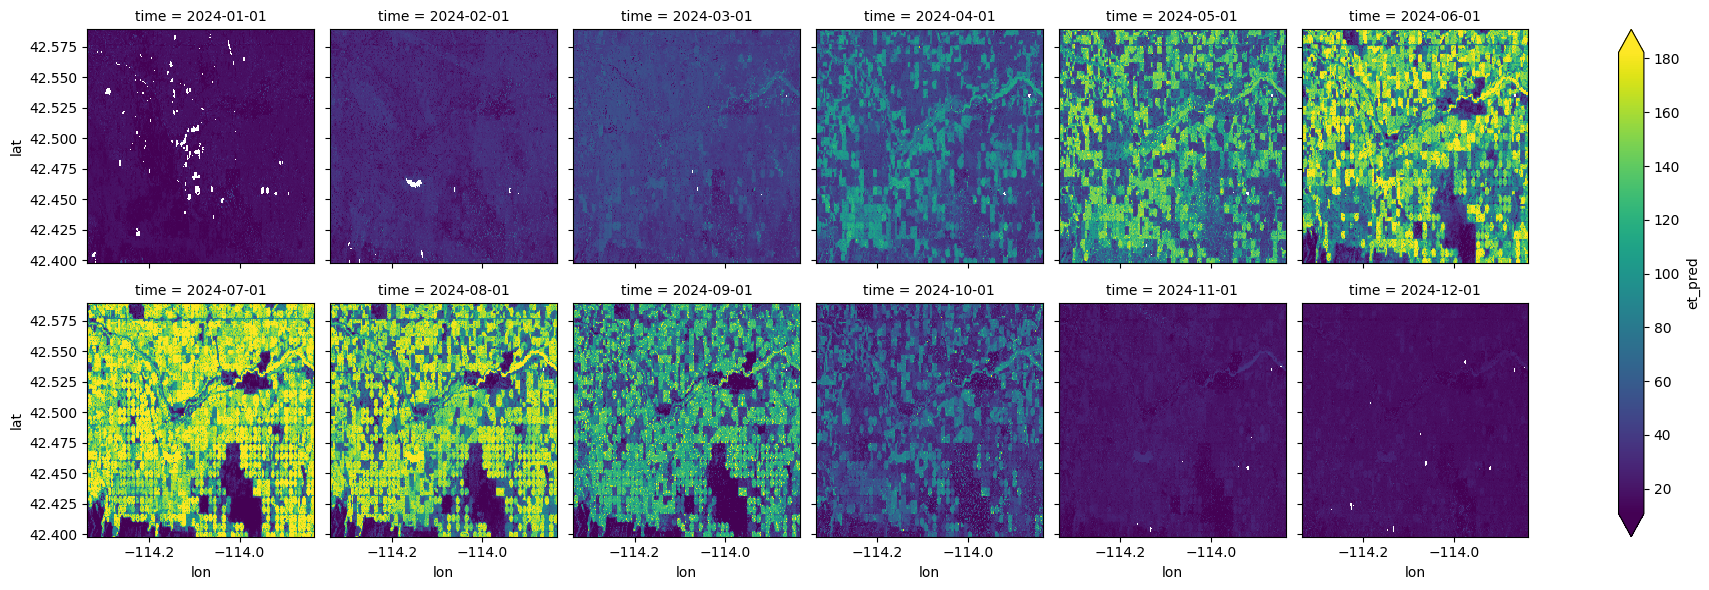

In [36]:
dfx.et_pred.plot(
    x = 'lon',
    y = 'lat',
    robust = True,
    col = 'time',
    col_wrap = 6
)

In [41]:
#Map = geemap.Map(center=[30.47, 67.68], zoom=13)
#Map.add_basemap('Google Satellite')
#Map.add_basemap('Google Hybrid')
map2 = geemap.Map(basemap = 'SATELLITE',center=[30.47, 67.68], zoom=13)

map2

Map(center=[30.47, 67.68], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [42]:
roi2 = map2.draw_last_feature.geometry()

roi2

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          67.346211,
                          30.330213
                        ],
                        [
                          67.347584,
                          30.604822
                        ],
                        [
                          67.725221,
                          30.60364
                        ],
                        [
                          67.72934,
                          30.319544
                        ],
                        [
                          67.346211,
                          30.330213
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [43]:
l8_2 = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate(time_start, time_end)
    .filterBounds(roi2)
    .map(oli)
)

l9_2 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(time_start, time_end)
    .filterBounds(roi2)
    .map(oli)
)
landsat2 = l8_2.merge(l9_2).sort('system:time_start')

landsat_monthly2 = (
    ee.ImageCollection(time_list.map(lambda x: monthly(x, landsat2)))
)

landsat_monthly2

In [44]:
ds2 = xr.open_dataset(
    landsat_monthly2,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 0.0003,
    geometry = roi2
)

In [45]:
ds2 = ds2.sortby('time') * 1

In [46]:
df2 = ds2.to_dataframe()
df2

ndvi         lst
time       lon       lat                            
2024-01-01 67.346361 30.319694  0.118373  287.327271
                     30.319994  0.126304  286.305267
                     30.320294  0.115237  285.618256
                     30.320594  0.121207  285.057709
                     30.320894  0.087666  284.411713
...                                  ...         ...
2024-12-01 67.729161 30.603494  0.251561  282.032745
                     30.603794  0.225296  282.931702
                     30.604094  0.205764  283.355530
                     30.604394  0.196652  284.025452
                     30.604694  0.177390  284.377533

[14573124 rows x 2 columns]

In [47]:
df2['et'] = model.predict(df2[['ndvi', 'lst']])

In [49]:
dfx2 = df2.to_xarray().sortby(['lat', 'lon', 'time'])

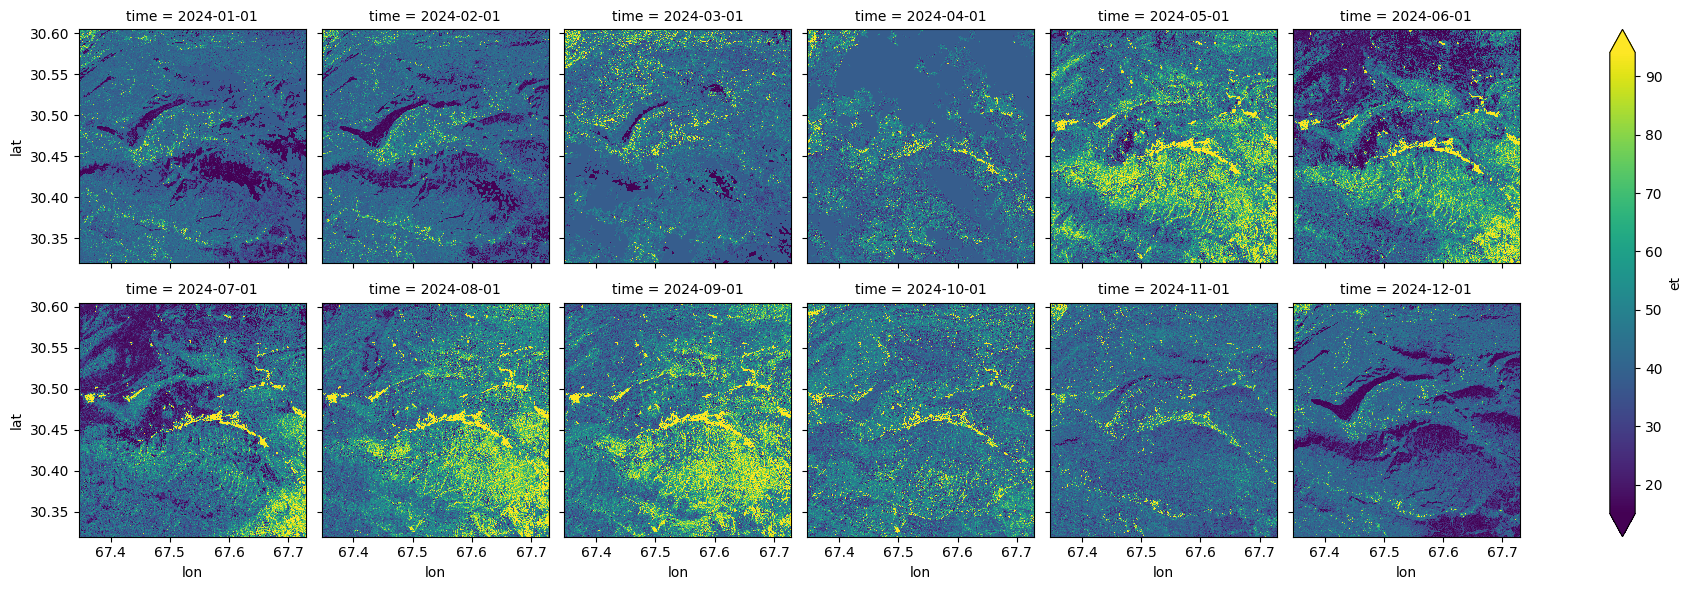

In [51]:
dfx2.et.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap = 6,
    robust = True
)

<Axes: xlabel='time'>

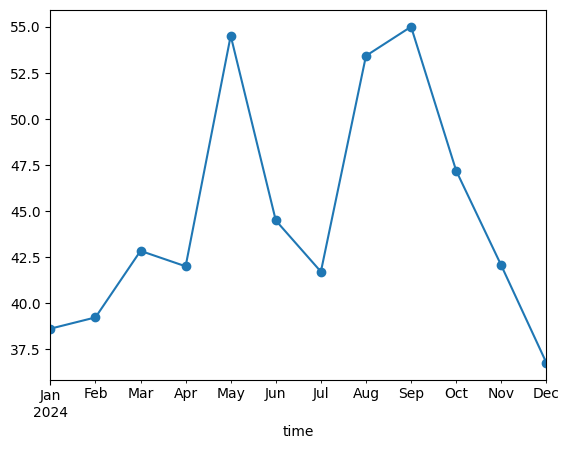

In [52]:
et_mean = dfx2.mean(dim = ['lat', 'lon']).to_dataframe()['et']
et_mean.plot(marker = 'o')